# Using Onnx Global planner

This notebook uses ONNX model version of global planner to predict candidate waypoint probabilities and draws resulting map. There should be no PyTorch dependencies in related code as this global planner will be used without Pytorch on the deployment platform (Jackal etc.).

In [1]:
%cd ..

/home/romet/projects/ut/milrem/global_planner


In [2]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import yaml

from data.mapping import MapReader
from models.global_planner_onnx import GlobalPlannerOnnx
from viz.util import calculate_north_heading


warnings.filterwarnings('ignore')

np.set_printoptions(suppress=True, precision=4)

%load_ext autoreload
%autoreload 2

## Predict probabilities

In [3]:
# Load configration
with open("config/default_segment.yaml", "r") as f:
    config = yaml.safe_load(f)

with open("config/env.yaml", "r") as f:
    env_config = yaml.safe_load(f)
    config.update(env_config)

# Load map
map_type = "baseelev" # "orienteering"
map_path = f"{config['map_path']}/Ihaste_{map_type}.tif"
map_reader = MapReader(map_path, config["map_size"])

# Gnss latitude, longitude coordinates of current and goal positions
current_position = [58.34925405, 26.78243032]
goal_position = [58.35010347, 26.78344511]

# Create probability map
# For Pytorch model use:
# global_planner = GlobalPlannerTorch(map_reader, config, "model_weights/distance_segment.ckpt")
global_planner = GlobalPlannerOnnx(map_reader, config, "model_weights/distance_segment.onnx")
global_planner.predict_probabilities(current_position, goal_position)

# Candidate waypoint relative to current position in meters, these should come from local planner.
# Weirdly local planner encodes positive y to the left and negative y to the right.
trajectories = np.array([
    [(10., 0.), (20., 0.), (30., 0.), (40., 0.), (50., 0.)], # Straight line towards the goal
    [(5., -5.), (10., -10.), (15., -15.), (20., -25.), (25., -40.)], # Curved to the right
    [(5., 5.), (10., 10.), (15., 15.), (20., 25.), (25., 40.)], # Curved to the left
])
relative_waypoints = trajectories.reshape((-1, 2))
north_heading = 45.0
# Calculate probabilities for each waypoint
probs = global_planner.calculate_probs(relative_waypoints, current_position, north_heading)

## Visualize

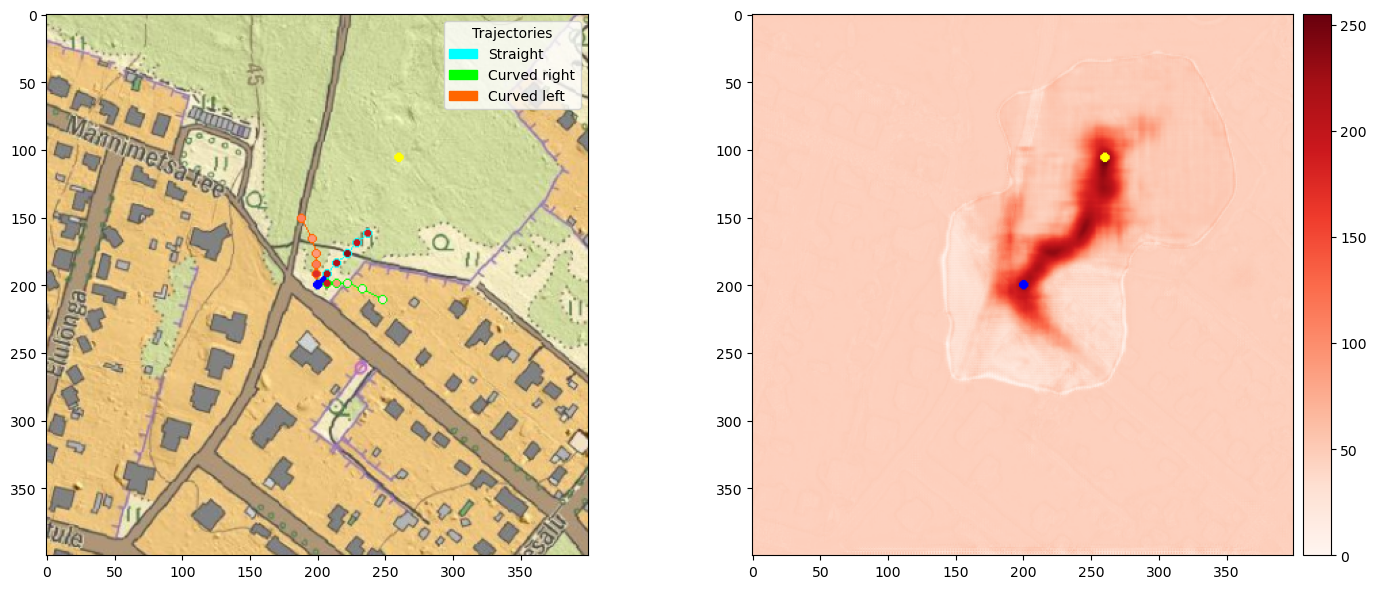

In [4]:
import matplotlib.patches as mpatches
from viz.global_planner_viz import GlobalPlannerViz
from viz.global_planner_viz import CYAN, GREEN, ORANGE


# Assign colors to different trajectories
trajectory_colors = [CYAN, GREEN, ORANGE]

# Display images
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Draw candidate waypoints map
global_planner_viz = GlobalPlannerViz(global_planner)
waypoints_img = global_planner_viz.plot_trajectories_map(current_position, goal_position, north_heading, trajectories, trajectory_colors)
axs[0].imshow(waypoints_img, vmin=0, vmax=1)

to_color = lambda t : (t[0]/255, t[1]/255, t[2]/255)
patch1 = mpatches.Patch(color=to_color(trajectory_colors[0]), label='Straight')
patch2 = mpatches.Patch(color=to_color(trajectory_colors[1]), label='Curved right')
patch3 = mpatches.Patch(color=to_color(trajectory_colors[2]), label='Curved left')
axs[0].legend(handles=[patch1, patch2, patch3], loc='upper right', title='Trajectories')

# Draw probability map
probability_map_img = global_planner_viz.plot_probability_map(current_position, goal_position)
im1 = axs[1].imshow(probability_map_img, cmap="Reds")
divider1 = make_axes_locatable(axs[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im1, cax=cax1)

plt.tight_layout()
plt.show()